# nnUNet Model Results Analysis

This notebook provides analysis and visualization of the nnUNet model results. It summarizes evaluation metrics (Dice, HD95, ASSD, overlap, component sizes), merges them with metadata, and visualizes softmax probability maps to assess segmentation performance.

In [1]:
import pandas as pd
import re

In [2]:
# Read evaluation results for all three test sets
metrics_cnc = pd.read_csv("data/nnUnet/metrics_d-cnc-test.csv", sep=",")
metrics_expert_c = pd.read_csv("data/nnUnet/metrics_d-expert-c.csv", sep=",")
metrics_expert_nc = pd.read_csv("data/nnUnet/metrics_d-expert-nc.csv", sep=",")

# Read metadata
metadata = pd.read_json("data/metadata_ku.json", lines=True)

### Get overall results per test set

In [3]:
evaluation_results_df = metrics_cnc #change to metrics_expert_c or metrics_expert_nc as needed

# Group by filename and keep only the first row per file
evaluation_results_df = evaluation_results_df.groupby("filename").first().reset_index()

# Extract subject ID from evaluation results filename
def extract_sub_id(filename):
    match = re.match(r"colon_(0*\d+)-", filename)
    if match:
        return f"sub{int(match.group(1)):03d}"
    return None

evaluation_results_df["sub_id"] = evaluation_results_df["filename"].apply(extract_sub_id)

metadata_unique = metadata.groupby("new_sub_id").first().reset_index()

# --- Merge evaluation results with metadata on subject ID (per scan) ---
merged_df = pd.merge(
    evaluation_results_df,   # <-- use per-scan DataFrame!
    metadata_unique,
    left_on="sub_id",
    right_on="new_sub_id",
    how="left"
)

# Map all genders except 'M' and 'F' to 'U'
merged_df["gender"] = merged_df["gender"].apply(lambda x: x if x in ["M", "F"] else "U")


# --- Example: Analyze average Dice score by gender (per scan) ---
gender_dice = merged_df.groupby("gender")["overall_dice_score"].mean()
print("Average Dice Score by Gender (per scan):")
print(gender_dice)

# --- Example: Analyze average HD95 by gender (per scan) ---
gender_hd95 = merged_df.groupby("gender")["overall_hausdorff_distance_95th"].mean()
print("\nAverage HD95 by Gender (per scan):")
print(gender_hd95)

# --- Example: Analyze average ASSD by gender (per scan) ---
gender_assd = merged_df.groupby("gender")["overall_average_symmetric_surface_distance"].mean()
print("\nAverage ASSD by Gender (per scan):")
print(gender_assd)

# --- Overall scores (per scan) ---
overall_dice = merged_df["overall_dice_score"].mean()
overall_hd95 = merged_df["overall_hausdorff_distance_95th"].mean()
overall_assd = merged_df["overall_average_symmetric_surface_distance"].mean()
print("\nOverall Scores (per scan):")
print(f"Overall Dice Score: {overall_dice:.4f}")
print(f"Overall HD95: {overall_hd95:.4f}")
print(f"Overall ASSD: {overall_assd:.4f}")

# --- (Optional) Show counts per gender ---
print("\nCounts per gender (per scan):")
print(merged_df.groupby("new_sub_id")["gender"].first().value_counts())

Average Dice Score by Gender (per scan):
gender
F    0.972305
M    0.970581
U    0.968027
Name: overall_dice_score, dtype: float64

Average HD95 by Gender (per scan):
gender
F    4.060002
M    2.536208
U    2.522046
Name: overall_hausdorff_distance_95th, dtype: float64

Average ASSD by Gender (per scan):
gender
F    0.607423
M    0.574320
U    0.527572
Name: overall_average_symmetric_surface_distance, dtype: float64

Overall Scores (per scan):
Overall Dice Score: 0.9712
Overall HD95: 3.2554
Overall ASSD: 0.5856

Counts per gender (per scan):
gender
M    41
F    39
U     8
Name: count, dtype: int64


In [9]:
# Extract position (supine/prone) from filename
evaluation_results_df["position"] = evaluation_results_df["filename"].str.extract(r"-(prone|supine)")

# Compute average metrics per position
metrics_per_position = evaluation_results_df.groupby("position")[[
    "overall_dice_score",
    "overall_hausdorff_distance_95th",
    "overall_average_symmetric_surface_distance"
]].mean()

print("Average metrics per position (per scan):")
metrics_per_position

Average metrics per position (per scan):


,overall_dice_score,overall_hausdorff_distance_95th,overall_average_symmetric_surface_distance
position,,,
prone,0.969369,3.598306,0.620593
supine,0.973155,2.873238,0.546644


### Investigate correlation between metrics

In [11]:
# Group by filename and extract the unique metric values
overall_hd95_per_file = evaluation_results_df.groupby("filename")["overall_hausdorff_distance_95th"].first()
overall_dice_per_file = evaluation_results_df.groupby("filename")["overall_dice_score"].first()
overall_assd_per_file = evaluation_results_df.groupby("filename")["overall_average_symmetric_surface_distance"].first()

# Combine the metrics into a single DataFrame
metrics_df = pd.DataFrame({
    "HD95": overall_hd95_per_file,
    "Dice": overall_dice_per_file,
    "ASSD": overall_assd_per_file
})

# Compute the correlation matrix
correlation_matrix = metrics_df.corr()

print("Correlation matrix:")
print(correlation_matrix)

Correlation matrix:
          HD95      Dice      ASSD
HD95  1.000000 -0.716171  0.952422
Dice -0.716171  1.000000 -0.826941
ASSD  0.952422 -0.826941  1.000000


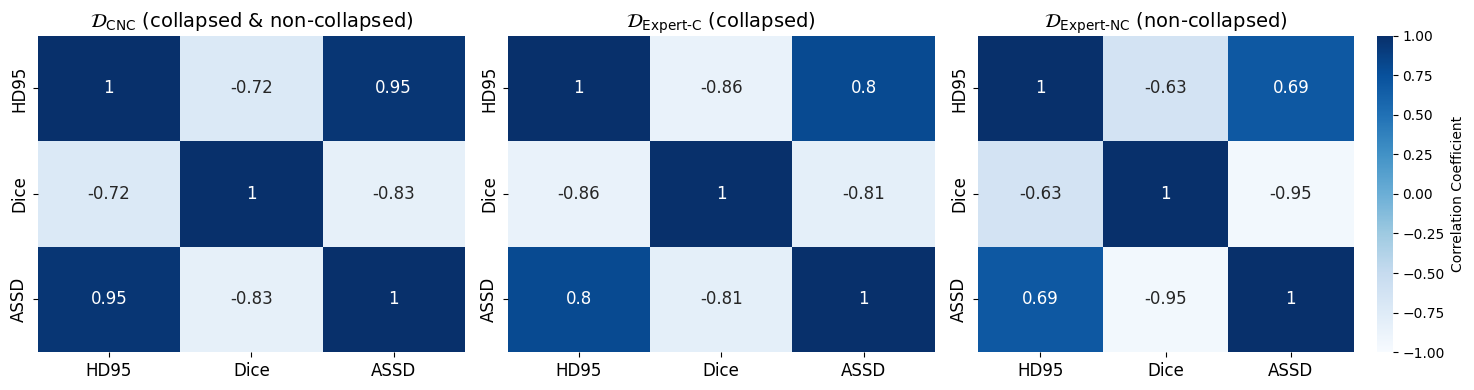

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Correlation matrices (obtained from the previous cell)
corr_d_all = pd.DataFrame([
    [1.000, -0.716, 0.952],
    [-0.716, 1.000, -0.827],
    [0.952, -0.827, 1.000]
], columns=["HD95", "Dice", "ASSD"], index=["HD95", "Dice", "ASSD"])

corr_d_collapsed = pd.DataFrame([
    [1.000, -0.856, 0.797],
    [-0.856, 1.000, -0.812],
    [0.797, -0.812, 1.000]
], columns=["HD95", "Dice", "ASSD"], index=["HD95", "Dice", "ASSD"])

corr_nc = pd.DataFrame([
    [1.000, -0.632, 0.691],
    [-0.632, 1.000, -0.948],
    [0.691, -0.948, 1.000]
], columns=["HD95", "Dice", "ASSD"], index=["HD95", "Dice", "ASSD"])

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw={'width_ratios': [1, 1, 1.1]})

# Set common color range and palette
vmin, vmax = -1, 1
cmap = "Blues"
fontsize_labels = 12  # x/y tick labels
fontsize_annot = 12   # inside heatmap numbers
fontsize_title = 14   # title size

# Plot heatmaps
sns.heatmap(corr_d_all, annot=True, annot_kws={"size": fontsize_annot},
            cmap=cmap, vmin=vmin, vmax=vmax, ax=axes[0], cbar=False)
axes[0].set_title(r"$\mathcal{D}_{\text{CNC}}$ (collapsed & non-collapsed)", fontsize=fontsize_title)
axes[0].tick_params(axis='both', labelsize=fontsize_labels)

sns.heatmap(corr_d_collapsed, annot=True, annot_kws={"size": fontsize_annot},
            cmap=cmap, vmin=vmin, vmax=vmax, ax=axes[1], cbar=False)
axes[1].set_title(r"$\mathcal{D}_{\text{Expert-C}}$ (collapsed)", fontsize=fontsize_title)
axes[1].tick_params(axis='both', labelsize=fontsize_labels)

sns.heatmap(corr_nc, annot=True, annot_kws={"size": fontsize_annot},
            cmap=cmap, vmin=vmin, vmax=vmax, ax=axes[2],
            cbar=True, cbar_kws={"label": "Correlation Coefficient"})
axes[2].set_title(r"$\mathcal{D}_{\text{Expert-NC}}$ (non-collapsed)", fontsize=fontsize_title)
axes[2].tick_params(axis='both', labelsize=fontsize_labels)

plt.tight_layout()
plt.show()


### Investigate component overlap with ground truth

In [18]:
evaluation_results_path = "data/nnUnet/metrics_d-cnc-test.csv"  # or metrics_d-expert-c.csv / metrics_d-expert-nc.csv
evaluation_results_df = pd.read_csv(evaluation_results_path, sep=",")

# Filter entries with component_size >= 10000 and overlap_percentage < 95%
filtered_entries = evaluation_results_df[
    (evaluation_results_df["component_size"] >= 10000) &
    # (evaluation_results_df["overlap_percentage"] >= 90) & (evaluation_results_df["overlap_percentage"] <= 95)
    # (evaluation_results_df["overlap_percentage"] >= 70) & (evaluation_results_df["overlap_percentage"] < 90)
    # (evaluation_results_df["overlap_percentage"] < 95)
    (evaluation_results_df["overlap_percentage"] < 95)
]

# Count the number of such entries
filtered_count = len(filtered_entries)

filtered_entries_grouped = filtered_entries.groupby("filename").agg({
    "component_size": "first",
    "overlap_percentage": "first",
    "overall_hausdorff_distance_95th": "first"
}).reset_index()
len(filtered_entries_grouped)

# Display the result
print(f"Number of entries with component size >= 10000 and overlap percentage < 95%: {filtered_count}")
print(f"Number of unique files with these criteria: {len(filtered_entries_grouped)}")

Number of entries with component size >= 10000 and overlap percentage < 95%: 30
Number of unique files with these criteria: 26


### Investigate voxel probability maps

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

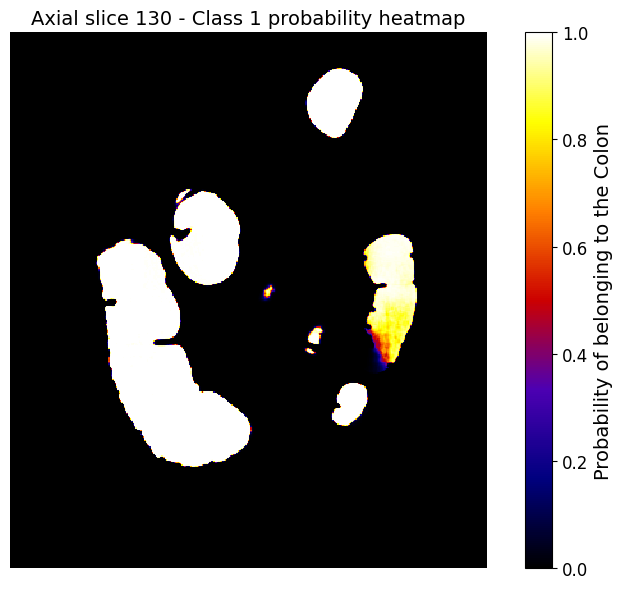

In [ ]:
# Load the softmax probabilities
npz_file_path = "data/nnUnet/npz/masks/colon_0218-supine.npz" # Change to your file path
data = np.load(npz_file_path)
softmax = data['probabilities']  # Shape: (num_classes, Z, Y, X)

# Select class and axial slice
class_idx = 1
axial_slice = 130
slice_heatmap = softmax[class_idx, :, axial_slice, :]

# Flip the image vertically
slice_heatmap_flipped = np.flipud(slice_heatmap)

# Create a custom colormap
colors = [
    (0.0, 0.0, 0.0),      # 0.0 -> black
    (0.0, 0.0, 0.5),      # dark blue
    (0.3, 0.0, 0.7),      # purple
    (0.8, 0.0, 0.0),      # red
    (1.0, 0.5, 0.0),      # orange
    (1.0, 1.0, 0.0),      # yellow
    (1.0, 1.0, 1.0),      # 1.0 -> white
]
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", colors, N=256)

# Plot heatmap
plt.figure(figsize=(8, 6))
img = plt.imshow(slice_heatmap_flipped, cmap=custom_cmap, vmin=0, vmax=1, interpolation='nearest')

# Get colorbar object and set font sizes
cbar = plt.colorbar(img)
cbar.set_label('Probability of belonging to the Colon', fontsize=14)       # Increase label font size
cbar.ax.tick_params(labelsize=12)                # Increase tick label font size

plt.title(f'Axial slice {axial_slice} - Class {class_idx} probability heatmap', fontsize=14)
plt.axis('off')  # Removes axis ticks and labels
plt.tight_layout()
plt.show()
